# Reconocimiento de dígitos con KNN

Veamos como interactuar con las clases implementadas en el módulo de C++ haciendo una experimentación muy simplificada, y a modo de ejemplo, del método KNN para reconocer digitos

## Compilando el módulo desde C++

Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [26]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/ariana/Dropbox/Métodos numéricos/mn_tp2/tp2/venv-tp2/bin/python (found version "3.8.10") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/ariana/Dropbox/Métodos numéricos

In [27]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum
import kfold
import numpy as np
import matplotlib.pyplot as plt

/home/ariana/Dropbox/Métodos numéricos/mn_tp2/tp2/notebooks
Python 3.8.10


## Explorando los datos

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [3]:
df_train[:10]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [4]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [5]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 7


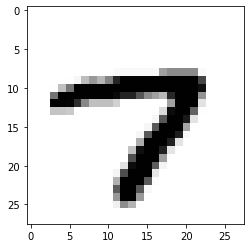

In [6]:
import matplotlib.pyplot as plt

num = 1917

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [7]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
8    0.0954
4    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [8]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Acá pueden cambiar el clasificador nuestro por el de sklearn!

clf = metnum.KNNClassifier(100)
#clf = KNeighborsClassifier(100)

clf.fit(X_train, y_train)


In [10]:
%%time
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Accuracy: {}".format(acc))


Accuracy: 0.832
CPU times: user 3.29 s, sys: 2.9 ms, total: 3.29 s
Wall time: 3.28 s


# Experimentacion con diferentes k y K

## Diferentes k

In [158]:
k_list = [x for x in range(1,40)]
K = 3
size = 25000

knn_accuracities_k = []
knn_Times_k = []
knn_Precision_k = []
knn_Recall_k = []
knn_F_Score_k = []

knn_Matrix_k = np.zeros((10,10))

for k in k_list:
    res =  kfold.tests_KFolds(k, K,False,0,"../data/train.csv",size)   
    knn_accuracities_k.append(res[0])    
    knn_Times_k.append(res[1])
    knn_Precision_k.append(res[2])
    knn_Recall_k.append(res[3])
    knn_F_Score_k.append(res[4])
    knn_Matrix_k=knn_Matrix_k+res[5]

knn_accuracities_k = np.asarray(knn_accuracities_k)
knn_Times_k = np.asarray(knn_Times_k)
knn_Precision_k=np.asarray(knn_Precision_k)
knn_Recall_k = np.asarray(knn_Recall_k)
knn_F_Score_k = np.asarray(knn_F_Score_k)

In [159]:
pca_accuracities_k = []
pca_Times_k = []
pca_Precision_k = []
pca_Recall_k = []
pca_F_Score_k = []

pca_Matrix_k = np.zeros((10,10))

for k in k_list:
    res =  kfold.tests_KFolds(k, K,True,32,"../data/train.csv",size)   
    pca_accuracities_k.append(res[0])    
    pca_Times_k.append(res[1])
    pca_Precision_k.append(res[2])
    pca_Recall_k.append(res[3])
    pca_F_Score_k.append(res[4])
    pca_Matrix_k=pca_Matrix_k+res[5]

pca_accuracities_k = np.asarray(pca_accuracities_k)
pca_Times_k = np.asarray(pca_Times_k)
pca_Precision_k = np.asarray(pca_Precision_k)
pca_Recall_k = np.asarray(pca_Recall_k)
pca_F_Score_k = np.asarray(pca_F_Score_k)

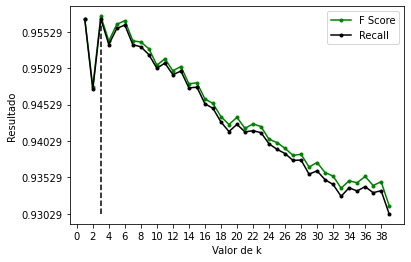

In [160]:
line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']

plt.plot(k_list,knn_F_Score_k, line_styles[2])
plt.plot(k_list,knn_Recall_k, line_styles[3])
plt.vlines(3, knn_Recall_k[-1], knn_Recall_k[2], linestyles ="dashed", colors ="k")
plt.ylabel("Resultado")
plt.xlabel("Valor de k")
plt.gca().legend(['F Score','Recall'])
plt.xticks(np.arange(min(k_list)-1, max(k_list)+1, 2.0))
plt.yticks(np.arange(min(knn_Recall_k), max(knn_F_Score_k), 0.005))
plt.savefig("expAcotados/k_exp_FRec_KNN.png", bbox_inches = "tight")

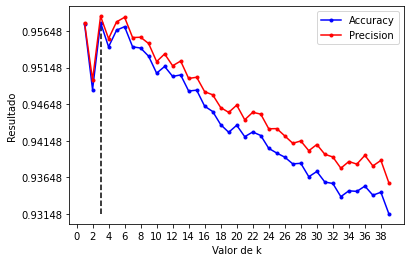

In [161]:
plt.plot(k_list,knn_accuracities_k, line_styles[0])
plt.plot(k_list,knn_Precision_k, line_styles[1])
plt.vlines(3, knn_accuracities_k[-1], knn_accuracities_k[2], linestyles ="dashed", colors ="k")
    
plt.ylabel("Resultado")
plt.xlabel("Valor de k")
plt.gca().legend(['Accuracy','Precision'])
plt.xticks(np.arange(min(k_list)-1, max(k_list)+1, 2.0))
plt.yticks(np.arange(min(knn_accuracities_k), max(knn_Precision_k), 0.005))
plt.savefig("expAcotados/k_exp_AccPrec_KNN.png", bbox_inches = "tight")

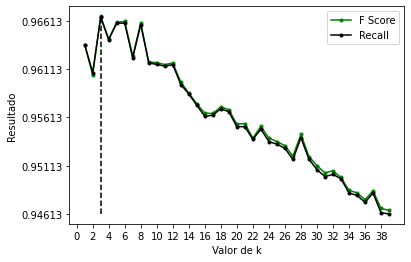

In [162]:
line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']

plt.plot(k_list,pca_F_Score_k, line_styles[2])
plt.plot(k_list,pca_Recall_k, line_styles[3])
plt.vlines(3, pca_Recall_k[-1], pca_Recall_k[2], linestyles ="dashed", colors ="k")
plt.ylabel("Resultado")
plt.xlabel("Valor de k")
plt.gca().legend(['F Score','Recall'])
plt.xticks(np.arange(min(k_list)-1, max(k_list)+1, 2.0))
plt.yticks(np.arange(min(pca_Recall_k), max(pca_F_Score_k), 0.005))
plt.savefig("expAcotados/k_exp_FRec_PCA.png", bbox_inches = "tight")

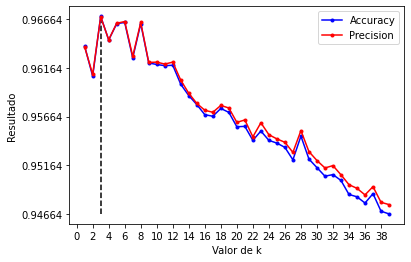

In [163]:
plt.plot(k_list,pca_accuracities_k, line_styles[0])
plt.plot(k_list,pca_Precision_k, line_styles[1])
plt.vlines(3, pca_accuracities_k[-1], pca_accuracities_k[2], linestyles ="dashed", colors ="k")
    
plt.ylabel("Resultado")
plt.xlabel("Valor de k")
plt.gca().legend(['Accuracy','Precision'])
plt.xticks(np.arange(min(k_list)-1, max(k_list)+1, 2.0))
plt.yticks(np.arange(min(pca_accuracities_k), max(pca_Precision_k), 0.005))
plt.savefig("expAcotados/k_exp_AccPrec_PCA.png", bbox_inches = "tight")

array([0.96388001, 0.96080001, 0.96696001, 0.96451992, 0.96620005,
       0.96631995, 0.96268001, 0.96619996, 0.96215992, 0.96199992,
       0.96188012, 0.9619199 , 0.95996012, 0.95880005, 0.95788003,
       0.95683998, 0.95668006, 0.95747998, 0.95707996, 0.95560013,
       0.95564001, 0.95420002, 0.95515998, 0.95420003, 0.95391981,
       0.95347996, 0.95220007, 0.95464005, 0.95228004, 0.95140006,
       0.9505201 , 0.95068015, 0.95007995, 0.94863989, 0.94839993,
       0.94776009, 0.94871985, 0.94692002, 0.94664016])

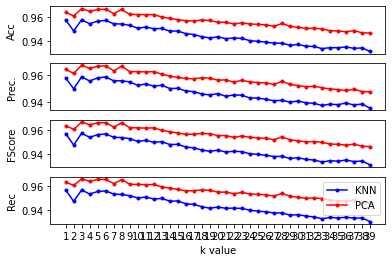

In [164]:
line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']

plt.subplot(4, 1, 1)
plt.plot(k_list,knn_accuracities_k, line_styles[0])
plt.plot(k_list,pca_accuracities_k, line_styles[1])
plt.ylabel("Acc")
plt.xticks([])

plt.subplot(4, 1, 2)
plt.plot(k_list,knn_Precision_k, line_styles[0])
plt.plot(k_list,pca_Precision_k, line_styles[1])
plt.ylabel("Prec.")
plt.xticks([])

plt.subplot(4, 1, 3)
plt.plot(k_list,knn_F_Score_k, line_styles[0])
plt.plot(k_list,pca_F_Score_k, line_styles[1])
plt.ylabel("FScore")
plt.xticks([])
    
plt.subplot(4, 1, 4)
plt.plot(k_list,knn_Recall_k, line_styles[0])
plt.plot(k_list,pca_Recall_k, line_styles[1])
plt.ylabel("Rec")
plt.xticks([])

    
plt.xlabel("k value")
plt.xticks(k_list)
# plt.axis([1, alphas[-1], 0.1, 1])
plt.gca().legend(['KNN','PCA'])
plt.savefig("expAcotados/k_exp_metrics.png")
pca_accuracities_k

[[9.47690e+04 5.60000e+01 5.80000e+01 1.30000e+01 2.60000e+01 2.13000e+02
  6.10000e+02 2.40000e+01 4.70000e+01 6.60000e+01]
 [0.00000e+00 1.07992e+05 2.07000e+02 6.80000e+01 1.11000e+02 5.00000e+00
  8.40000e+01 1.29000e+02 2.50000e+01 4.40000e+01]
 [1.20900e+03 3.03300e+03 8.85280e+04 5.85000e+02 2.21000e+02 1.72000e+02
  3.38000e+02 2.54600e+03 4.84000e+02 2.39000e+02]
 [1.96000e+02 9.84000e+02 6.24000e+02 9.50440e+04 5.00000e+01 1.26100e+03
  1.69000e+02 9.64000e+02 7.65000e+02 7.40000e+02]
 [7.30000e+01 1.83700e+03 3.00000e+00 0.00000e+00 8.79650e+04 1.90000e+01
  4.55000e+02 2.32000e+02 1.90000e+01 3.66700e+03]
 [4.54000e+02 8.53000e+02 2.60000e+01 1.87300e+03 2.46000e+02 8.22740e+04
  1.24500e+03 9.60000e+01 1.50000e+02 1.04900e+03]
 [8.67000e+02 4.83000e+02 2.00000e+01 5.00000e+00 1.36000e+02 5.83000e+02
  9.38320e+04 7.00000e+00 3.50000e+01 0.00000e+00]
 [8.50000e+01 2.65000e+03 2.68000e+02 1.80000e+01 3.40000e+02 2.30000e+01
  1.00000e+01 9.69650e+04 2.00000e+00 1.79300e+03]


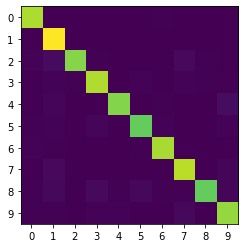

In [165]:
print(knn_Matrix_k)
plt.imshow(knn_Matrix_k)
plt.xticks(np.arange(0,10))
plt.yticks(np.arange(0,10));
plt.savefig("expAcotados/k_exp_matrix.png")

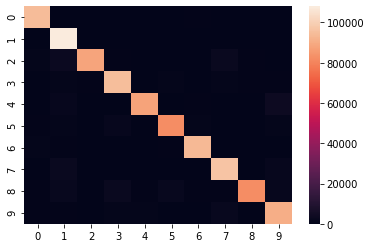

In [166]:
import seaborn as sns

heatmap = sns.heatmap(knn_Matrix_k)
fig = heatmap.get_figure()
fig.savefig("expAcotados/k_exp_heat.png")

## Diferentes K

In [142]:
K_list = [x for x in range(1,40)]
k = 3
size = 25000

knn_accuracities_K = []
knn_Times_K = []
knn_Precision_K = []
knn_Recall_K = []
knn_F_Score_K = []

knn_Matrix_K = np.zeros((10,10))

for k in K_list:
    res =  kfold.tests_KFolds(k, K,False,8,"../data/train.csv",size)   
    knn_accuracities_K.append(res[0])    
    knn_Times_K.append(res[1])
    knn_Precision_K.append(res[2])
    knn_Recall_K.append(res[3])
    knn_F_Score_K.append(res[4])
    knn_Matrix_K=knn_Matrix_K+res[5]

knn_accuracities_K = np.asarray(knn_accuracities_K)
knn_Times_K = np.asarray(knn_Times_K)
knn_Precision_K=np.asarray(knn_Precision_K)
knn_Recall_K = np.asarray(knn_Recall_K)
knn_F_Score_K = np.asarray(knn_F_Score_K)

In [143]:
pca_accuracities_K = []
pca_Times_K = []
pca_Precision_K = []
pca_Recall_K = []
pca_F_Score_K = []

pca_Matrix_K = np.zeros((10,10))

for k in K_list:
    res =  kfold.tests_KFolds(k, K,True,32,"../data/train.csv",size)   
    pca_accuracities_K.append(res[0])    
    pca_Times_K.append(res[1])
    pca_Precision_K.append(res[2])
    pca_Recall_K.append(res[3])
    pca_F_Score_K.append(res[4])
    pca_Matrix_K=pca_Matrix_K+res[5]

pca_accuracities_K = np.asarray(pca_accuracities_K)
pca_Times_K = np.asarray(pca_Times_K)
pca_Precision_K=np.asarray(pca_Precision_K)
pca_Recall_K = np.asarray(pca_Recall_K)
pca_F_Score_K = np.asarray(pca_F_Score_K)

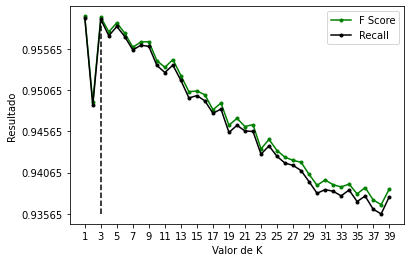

In [150]:
line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']

plt.plot(K_list,knn_F_Score_K, line_styles[2])
plt.plot(K_list,knn_Recall_K, line_styles[3])
plt.vlines(3, knn_Recall_K[-2], knn_Recall_K[2], linestyles ="dashed", colors ="k")
plt.ylabel("Resultado")
plt.xlabel("Valor de K")
plt.gca().legend(['F Score','Recall'])
plt.xticks(np.arange(min(K_list), max(K_list)+1, 2.0))
plt.yticks(np.arange(min(knn_Recall_K), max(knn_F_Score_K), 0.005))
plt.savefig("expAcotados/K_exp_FRec_KNN.png", bbox_inches = "tight")

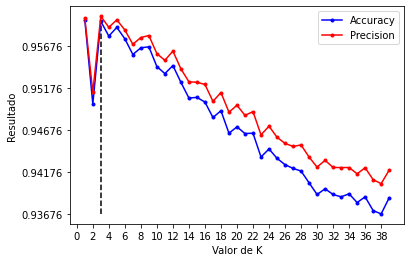

In [151]:
plt.plot(K_list,knn_accuracities_K, line_styles[0])
plt.plot(K_list,knn_Precision_K, line_styles[1])
plt.vlines(3, knn_accuracities_K[-2], knn_accuracities_K[2], linestyles ="dashed", colors ="k")
    
plt.ylabel("Resultado")
plt.xlabel("Valor de K")
plt.gca().legend(['Accuracy','Precision'])
plt.xticks(np.arange(min(K_list)-1, max(K_list)+1, 2.0))
plt.yticks(np.arange(min(knn_accuracities_K), max(knn_Precision_K), 0.005))
plt.savefig("expAcotados/K_exp_AccPrec_KNN.png", bbox_inches = "tight")

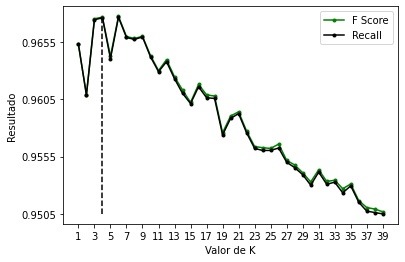

In [154]:
line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']

plt.plot(K_list,pca_F_Score_K, line_styles[2])
plt.plot(K_list,pca_Recall_K, line_styles[3])
plt.vlines(4, min(pca_Recall_K), pca_Recall_K[3], linestyles ="dashed", colors ="k")
plt.ylabel("Resultado")
plt.xlabel("Valor de K")
plt.gca().legend(['F Score','Recall'])
plt.xticks(np.arange(min(K_list), max(K_list)+1, 2.0))
plt.yticks(np.arange(min(pca_Recall_K), max(pca_F_Score_K), 0.005))
plt.savefig("expAcotados/K_exp_FRec_PCA.png", bbox_inches = "tight")

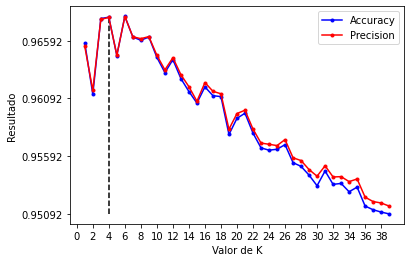

In [157]:
plt.plot(K_list,pca_accuracities_K, line_styles[0])
plt.plot(K_list,pca_Precision_K, line_styles[1])
plt.vlines(4, min(pca_accuracities_K), pca_accuracities_K[3], linestyles ="dashed", colors ="k")
    
plt.ylabel("Resultado")
plt.xlabel("Valor de K")
plt.gca().legend(['Accuracy','Precision'])
plt.xticks(np.arange(min(K_list)-1, max(K_list)+1, 2.0))
plt.yticks(np.arange(min(pca_accuracities_K), max(pca_Precision_K), 0.005))
plt.savefig("expAcotados/K_exp_AccPrec_PCA.png", bbox_inches = "tight")

array([0.95996, 0.94992, 0.95976, 0.958  , 0.95904, 0.95768, 0.9558 ,
       0.9566 , 0.95672, 0.95436, 0.95352, 0.95448, 0.95248, 0.9506 ,
       0.95068, 0.95012, 0.94828, 0.94908, 0.9464 , 0.94716, 0.94636,
       0.9464 , 0.94356, 0.94452, 0.9434 , 0.94264, 0.9422 , 0.94188,
       0.94048, 0.93908, 0.93976, 0.93908, 0.9388 , 0.93916, 0.93812,
       0.9388 , 0.93716, 0.93676, 0.93868])

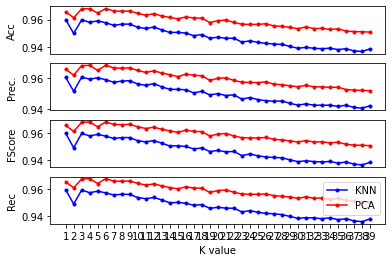

In [149]:
plt.subplot(4, 1, 1)
plt.plot(K_list,knn_accuracities_K, line_styles[0])
plt.plot(K_list,pca_accuracities_K, line_styles[1])
plt.ylabel("Acc")
plt.xticks([])

plt.subplot(4, 1, 2)
plt.plot(K_list,knn_Precision_K, line_styles[0])
plt.plot(K_list,pca_Precision_K, line_styles[1])
plt.ylabel("Prec.")
plt.xticks([])

plt.subplot(4, 1, 3)
plt.plot(K_list,knn_F_Score_K, line_styles[0])
plt.plot(K_list,pca_F_Score_K, line_styles[1])
plt.ylabel("FScore")
plt.xticks([])
    
plt.subplot(4, 1, 4)
plt.plot(K_list,knn_Recall_K, line_styles[0])
plt.plot(K_list,pca_Recall_K, line_styles[1])
plt.ylabel("Rec")
plt.xticks([])

    
plt.xlabel("K value")
plt.xticks(K_list)
# plt.axis([1, alphas[-1], 0.1, 1])
plt.gca().legend(['KNN','PCA'])
plt.savefig("expAcotados/K_exp_metrics.png")
knn_accuracities_K

# Experimentacion con diferente alpha

In [167]:
alpha_list = [x for x in range(1,100)]
k = 3
K = 3
size = 25000

pca_accuracities_alpha = []
pca_Times_alpha = []
pca_Precision_alpha = []
pca_Recall_alpha = []
pca_F_Score_alpha = []

pca_Matrix_alpha = np.zeros((10,10))

for alpha in alpha_list:
    res =  kfold.tests_KFolds(k, K,True,alpha,"../data/train.csv",size)   
    pca_accuracities_alpha.append(res[0])    
    pca_Times_alpha.append(res[1])
    pca_Precision_alpha.append(res[2])
    pca_Recall_alpha.append(res[3])
    pca_F_Score_alpha.append(res[4])
    pca_Matrix_alpha=pca_Matrix_alpha+res[5]

pca_accuracities_alpha = np.asarray(pca_accuracities_alpha)
pca_Times_alpha = np.asarray(pca_Times_alpha)
pca_Precision_alpha=np.asarray(pca_Precision_alpha)
pca_Recall_alpha = np.asarray(pca_Recall_alpha)
pca_F_Score_alpha = np.asarray(pca_F_Score_alpha)

array([0.26543994, 0.39688003, 0.44940034, 0.59524028, 0.71255987,
       0.8065599 , 0.84999992, 0.87840007, 0.89456002, 0.90943987,
       0.91664011, 0.93059995, 0.93415997, 0.94332005, 0.94536002,
       0.94972008, 0.95248004, 0.95440005, 0.95668015, 0.96072003,
       0.95967993, 0.96008012, 0.95891996, 0.96303994, 0.96415996,
       0.96319992, 0.96416002, 0.96472013, 0.96392007, 0.96631998,
       0.96631997, 0.96584   , 0.96523999, 0.96583991, 0.96556014,
       0.96696003, 0.96668012, 0.96463987, 0.96791996, 0.96744002,
       0.96480014, 0.96420002, 0.96687997, 0.96644001, 0.96567996,
       0.96579994, 0.96703998, 0.96524008, 0.96527997, 0.96467998,
       0.96451996, 0.96527996, 0.96623992, 0.96403997, 0.96360008,
       0.96420003, 0.9646    , 0.96604005, 0.96508002, 0.96412012,
       0.96532004, 0.96456011, 0.96240003, 0.96307996, 0.96559993,
       0.96383996, 0.9629999 , 0.96308002, 0.96528002, 0.9628    ,
       0.96460003, 0.96227997, 0.96127995, 0.96315999, 0.96495

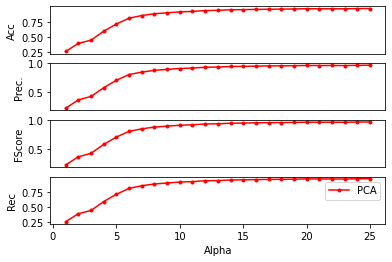

In [168]:
line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']
limit = 25
plt.subplot(4, 1, 1)
plt.plot(alpha_list[:limit],pca_accuracities_alpha[:limit], line_styles[1])
plt.ylabel("Acc")
plt.xticks([])

plt.subplot(4, 1, 2)
plt.plot(alpha_list[:limit],pca_Precision_alpha[:limit], line_styles[1])
plt.ylabel("Prec.")
plt.xticks([])

plt.subplot(4, 1, 3)
plt.plot(alpha_list[:limit],pca_F_Score_alpha[:limit], line_styles[1])
plt.ylabel("FScore")
plt.xticks([])
    
plt.subplot(4, 1, 4)
plt.plot(alpha_list[:limit],pca_Recall_alpha[:limit], line_styles[1])
plt.ylabel("Rec")
#plt.xticks([])

    
plt.xlabel("Alpha")
#plt.xticks(alpha_list[:limit])
plt.gca().legend(['PCA'])
plt.savefig("expAcotados/alpha_exp_metrics.png")
pca_accuracities_alpha

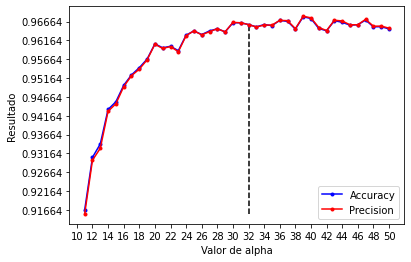

In [173]:
lower_limit = 10
upper_limit = 50

plt.plot(alpha_list[lower_limit:upper_limit],pca_accuracities_alpha[lower_limit:upper_limit], line_styles[0])
plt.plot(alpha_list[lower_limit:upper_limit],pca_Precision_alpha[lower_limit:upper_limit], line_styles[1])
plt.vlines(32, pca_Precision_alpha[lower_limit], pca_Precision_alpha[32], linestyles ="dashed", colors ="k")
    
plt.ylabel("Resultado")
plt.xlabel("Valor de alpha")
plt.gca().legend(['Accuracy','Precision'])
plt.xticks(np.arange(min(alpha_list[lower_limit:upper_limit])-1, max(alpha_list[lower_limit:upper_limit])+1, 2.0))
plt.yticks(np.arange(min(pca_accuracities_alpha[lower_limit:upper_limit]), max(pca_Precision_alpha[lower_limit:upper_limit]), 0.005))
plt.savefig("expAcotados/alpha_exp_AccPrec.png", bbox_inches = "tight")

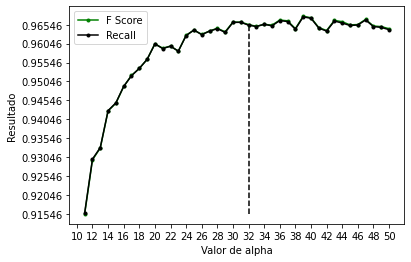

In [175]:
lower_limit = 10
upper_limit = 50

plt.plot(alpha_list[lower_limit:upper_limit],pca_F_Score_alpha[lower_limit:upper_limit], line_styles[2])
plt.plot(alpha_list[lower_limit:upper_limit],pca_Recall_alpha[lower_limit:upper_limit], line_styles[3])
plt.vlines(32, pca_F_Score_alpha[lower_limit], pca_Recall_alpha[32], linestyles ="dashed", colors ="k")
    
plt.ylabel("Resultado")
plt.xlabel("Valor de alpha")
plt.gca().legend(['F Score','Recall'])
plt.xticks(np.arange(min(alpha_list[lower_limit:upper_limit])-1, max(alpha_list[lower_limit:upper_limit])+1, 2.0))
plt.yticks(np.arange(min(pca_F_Score_alpha[lower_limit:upper_limit]), max(pca_F_Score_alpha[lower_limit:upper_limit]), 0.005))
plt.savefig("expAcotados/alpha_exp_FRec.png", bbox_inches = "tight")

## Calculamos el accuracy alcanzado con los parámetros óptimos encontrados

### Utilizando K-fold cross-validation con $k = 3$, $ \alpha = 32$ y $ K = 10 $

In [18]:
res =  kfold.tests_KFolds(3, 10,True,32,"../data/train.csv", 42000)

In [23]:
res[0]

0.9741666666666667

### Utilizando validación porcentual con $k = 3$ y $ \alpha = 32 $

In [ ]:
import split
res_prom = []
for i in range (20):
    res_prom.append(split.tests_split(3, True , 32, "../data/train.csv", 42000))

In [ ]:
acc_prom = []
for i in range (20):
    acc_prom.append(res_prom[i][0])
acc_prom 

In [ ]:
np.mean(acc_prom)